# Chainrules: custom AD in julia

In this tutorial, we will look at the automatic differentiation in julia, and in particular how `[ChainRules.jl](https://github.com/JuliaDiff/ChainRules.jl)` supports addition of your own differentiation rules into Julia's [Automatic Differentiation](https://juliadiff.org) system. This allows for seamless integration between your code, including its handcoded derivatives, and Julia's native AD systems, e.g. those used by [Flux](https://fluxml.ai/Flux.jl/stable/) Julia's machine learning platform. We use [ChainRules.jl](https://github.com/JuliaDiff/ChainRules.jl) to automatically differentiate codes that involve complex operations implemented by [JUDI.jl](https://github.com/slimgroup/JUDI.jl) (this example) and [JOLI.jl](https://github.com/slimgroup/JOLI.jl).

In [1]:
using Flux, ChainRulesCore, LinearAlgebra

## Simple example

Let's consider a simple example with a basic differentiable function $x -> cos(x) + 1$

In [2]:
mycos(x) = cos(x) + 1

mycos (generic function with 1 method)

Now we know that the derivative of this function is $x -> -sin(x)$ from standard functional analysis.e can therefore define through chainrules a new rule for our function `f`

In [3]:
function ChainRulesCore.rrule(::typeof(mycos), x)
    println("Using custom AD rule for mycos")
    y = mycos(x)
    pullback(Δy) = (NoTangent(), -sin(x)*Δy)
    return y, pullback
end

We now have the rule to compute the directional derivative of our function `mycos` . Let's check the gradient

In [4]:
x0 = randn()
# Standard AD of cos
g1 = gradient(x->norm(cos(x)+1)^2, x0);
# Our definition
g2 = gradient(x->norm(mycos(x))^2, x0);
# Analytical gradient
g3 = -2*sin(x0)*(mycos(x0));
println("True gradient: $(g3) \nStandard AD  : $(g1[1]) \nCustom AD    : $(g2[1])")

Using custom AD rule for mycos
True gradient: -1.8649005026115064 
Standard AD  : -1.8649005026115064 
Custom AD    : -1.8649005026115064


And we see that we get the correct gradient. Nw this is an extremely simple case, now let's look at a more complicated case where we define the AD rule for matrix-free operators defined in JOLI

# JOLI

We look at how we define automatic differentiation rules involding matrix-free linear operator. We consider operations of the form `A*x` where `A` is a JOLI matrix-free linear operator and we differentiate with respect to the input `x`

In JOLI, the base type of our linear operator is `joAbstractLinearOperator`. If we define the rule for this abstract type, all linear operator should follow. Now in this case the acual operation to be differentiated is the multiplication `*` with two inputs (`A, x`). Because we consider `A` to be fixed,its derivative will be defined as `NoTangent` that is `ChainRules`'s way to state there is no derivative for this input.

In [5]:
using JOLI

In [6]:
function ChainRulesCore.rrule(::typeof(*), A::T, x) where {T<:joAbstractLinearOperator}
    y = A*x
    pullback(Δy) = (NoTangent(), NoTangent(), A'*Δy)
    return y, pullback
end

With this rule defined we can now use a JOLI operator. Let's solve a simple data fitting problem with a restricted Fourier measuerment


In [7]:
using Random
N = 128
# Fourier transform as a linear operator
F = joDFT(N)
# Restriction
R = joRomberg(N; DDT=Complex{Float64}, RDT=Complex{Float64})
# Combine the operators
A = R*F;

In [8]:
# Make data
x = randn(128)
b = A*x;

Let's create a loss function

In [9]:
loss(x) = .5f0*norm(A*x - b)^2 + norm(A*x - b, 1)

loss (generic function with 1 method)

We can now easily obtain the gradient at any given `x` since the only undefined part would have been the JOLI operator that now has its own differentiation rule

In [10]:
gradient(loss, randn(128))

([0.13474305114511181, 0.2869709188435244, 3.633360606648581, 0.05113366965278532, 2.5686143424000853, -0.25070533176953763, 3.551231101753184, -2.885755896429605, 5.560390621099328, 2.3162055748862684  …  2.3271984199565323, -0.5072157359476902, 0.6859538088641302, -4.768927839775275, 2.39302573295268, 5.241514241351331, 1.6452505110584625, 0.6377236583016264, -2.678395044585236, -0.2697952112498267],)

### Optimization
Let's now slve the problem above with standard gradient descent

In [11]:
using Optim

In [12]:
δloss!(g, x) = begin g.=gradient(loss, x)[1]; return loss(x) end;

In [13]:
sol = optimize(loss, δloss!, randn(N), ConjugateGradient(),
                   Optim.Options(g_tol = 1e-12, iterations = 200, store_trace = true, show_trace = true, show_every=1))

Iter     Function value   Gradient norm 
     0     2.695805e+02     6.804750e+00
 * time: 0.022671937942504883
     1     1.708839e+02     5.369350e+00
 * time: 1.3831229209899902
     2     7.217453e+00     2.762446e+00
 * time: 1.6056859493255615
     3     3.716482e+00     2.448193e+00
 * time: 1.7042651176452637
     4     2.084910e+00     2.672717e+00
 * time: 1.9161639213562012
     5     1.169315e+00     2.680530e+00
 * time: 2.28397798538208
     6     7.702332e-01     2.991126e+00
 * time: 2.5992629528045654
     7     4.573554e-01     2.542154e+00
 * time: 2.773646116256714
     8     3.773742e-01     2.381621e+00
 * time: 2.939305067062378
     9     2.299894e-01     2.444437e+00
 * time: 3.2251839637756348
    10     1.630411e-01     2.230786e+00
 * time: 3.405548095703125
    11     9.392154e-02     2.316834e+00
 * time: 3.6459739208221436
    12     2.890879e-02     2.228269e+00
 * time: 3.8856630325317383
    13     1.838478e-02     2.428651e+00
 * time: 3.9636311531066

 * Status: success

 * Candidate solution
    Final objective value:     9.843769e-14

 * Found with
    Algorithm:     Conjugate Gradient

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 2.30e+00 ≰ 1.0e-12

 * Work counters
    Seconds run:   10  (vs limit Inf)
    Iterations:    61
    f(x) calls:    180
    ∇f(x) calls:   117


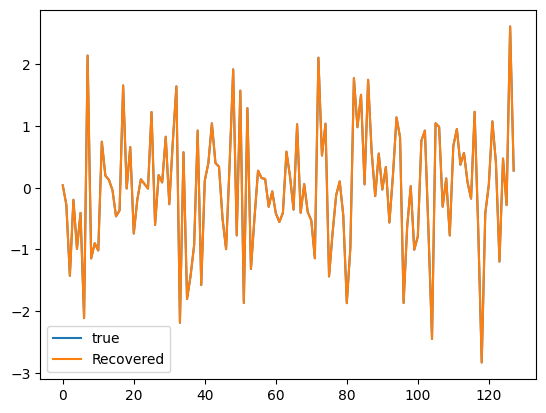

PyObject <matplotlib.legend.Legend object at 0x162d8d640>

In [14]:
using PyPlot
plot(x, label="true")
plot(sol.minimizer, label="Recovered")
legend()